# Prepare the Datatset and Collect Data
1. Transform time series into frequency domain
2. Resample the frequency spectra to the same lengths
2. Flatten the $N_s \times 16$ frequency matrix into a 1D vector
3. Stack the frequency vectors into a frequency matrix

In [1]:
import glob
import os
import re
import numpy as np
import pandas as pd
from bidict import bidict
from numpy.fft import rfft
from scipy.signal import resample
from torch.utils.data import Dataset
from torchvision import transforms


class Texture:
    """ Create a bidict from a texture name list."""

    def __init__(self, texture_names):
        self.texture_by_id = bidict()
        for i, tn in enumerate(set(texture_names)):
            self.texture_by_id[tn] = i

    def get_id(self, texture_name: str):
        return self.texture_by_id[texture_name]

    def get_name(self, texture_id: int):
        return self.texture_by_id.inverse[texture_id]


class TacDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.filelist = [y for x in os.walk(
            root_dir) for y in glob.glob(os.path.join(x[0], '*.csv'))]
        self.params = [(0.0, 0.0)] * len(self.filelist)
        self.texture_names = []
        for i, filename in enumerate(self.filelist):
            basename = os.path.basename(filename)
            namegroups = basename.split('_')

            self.texture_names.append(namegroups[0])
            self.params[i] = [int(re.search(r"\d+", namegroups[1]).group(0)),
                              float(re.search(r"[-+]?\d+", namegroups[2]).group(0))]
        self.textures = Texture(self.texture_names)

    def __len__(self):
        return len(self.filelist)

    def __getitem__(self, index):
        filename = self.filelist[index]
        rawdata  = np.genfromtxt(filename, delimiter=',', skip_header=1)
        tacdata  = rawdata[:, 3:]
        texture_name = self.texture_names[index]
        if self.transform:
            tacdata = self.transform(tacdata)
        return tacdata, self.params[index], self.textures.get_id(texture_name)
    
    def count_class(self):
        return len(set(self.texture_names))

    def get_texture_name(self, texture_id):
        return self.textures.get_name(texture_id)

    
""" Custom transforms """

class Normalize(object):
    def __init__(self, axis=0):
        self.axis = axis

    def __call__(self, sample):
        return (sample - np.mean(sample, keepdims=True)) / np.std(sample, keepdims=True)
    
class ResampleFFT(object):
    def __init__(self, Ns, flatten=True, axis=0):
        self.Ns = Ns
        self.axis = axis
        self.flatten = flatten
    
    def __call__(self, x):
        y = rfft(x, axis=self.axis, norm="ortho")
        ys = np.abs(y)[1:, :]
        ys = resample(ys, self.Ns, axis=self.axis)
        if self.flatten:
            ys = ys.flatten()
        
        return ys
    
transform = transforms.Compose([Normalize(axis=1), ResampleFFT(64)])
ds = TacDataset('data', transform=transform)

""" Collect data and labels """
coeff_array = []
labels = []

for sample, param, label in ds:
    coeff_array.append(sample)
    texture, (p, s) = ds.get_texture_name(label), param
    labels.append((texture, label, p, s))

df_label = pd.DataFrame(labels, columns=["texture", "id", "pressure", "speed"])
coeffs = np.asarray(coeff_array)

# Utility Functions

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def split_train_test(x, y, use_texture=2, random_texture=True):
    """ split textures into (train, test and other) 3 groups """
    
    all_tex = y[~y["texture"].str.contains("Board")]["texture"].unique()
    if random_texture:
        np.random.shuffle(all_tex)
    
    def get_set(select):
        index = y[y["texture"].isin(select)].index
        label = y.iloc[index]
        coeff = x[index, :]
        
        label.reset_index(drop=True, inplace=True)
        
        return coeff, label
    
    select_train = all_tex[use_texture]
    select_test = [e for e in all_tex if e not in select_train]
    select_other = y[y["texture"].str.contains("Board")]["texture"].unique()
    
    train_x, train_y = get_set(select_train)
    test_x, test_y = get_set(select_test)
    other_x, other_y = get_set(select_other)
    
    return train_x, train_y, test_x, test_y, other_x, other_y

""" Ploting funtions """

def plot3d(x, y, items, selected=None, ax=None):
    if type(x) == pd.DataFrame:
        x = x.values
    df1 = pd.DataFrame(x[:, :3], columns=["x", "y", "z"])
    try:
        y = y.values
    except:
        y = y
    df2 = pd.DataFrame(y, columns=["texture", "id", "pressure", "speed"])
    df = pd.concat([df2, df1], axis=1)
    plot3df(df, items, selected, ax)

def plot3df(df, items, selected, ax=None):
    if selected is not None:
        df = df[df[items].isin(selected)]
    unique_item = df_label[items].unique()
    cmap = plt.cm.get_cmap("Set2", len(unique_item))
    colors = dict([(unique_item[i], cmap(i)) for i in range(len(unique_item))])
    
    if ax == None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    for item in df[items].unique():
        df_ = df[df[items] == item]
        color = np.asarray(colors[item])
        ax.scatter(df_["x"], df_["y"], df_["z"], marker="x" if len(df) > 1 else "o", s=20 if len(df) > 1 else 40, c=np.tile(color, (len(df_), 1)), label=item)
    plt.tight_layout()

# Iterative Feature Extractor in Frequency Domain
1. Use few samples as a prior knowledge to train a PCA compressor ($Ns \times 16$-D $\rightarrow n-$D)
2. For new samples, update the de-meaned frequency matrix
3. Apply iterative PCA to update the compressed frequency vector
4. Try to identify the fabric material under current *pressure* and *speed* settings

<IPython.core.display.Javascript object>


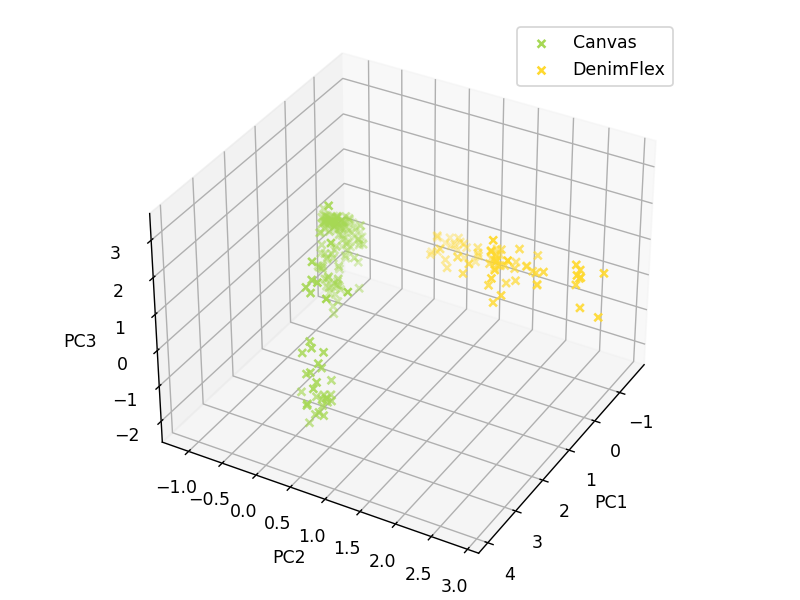

<IPython.core.display.Javascript object>


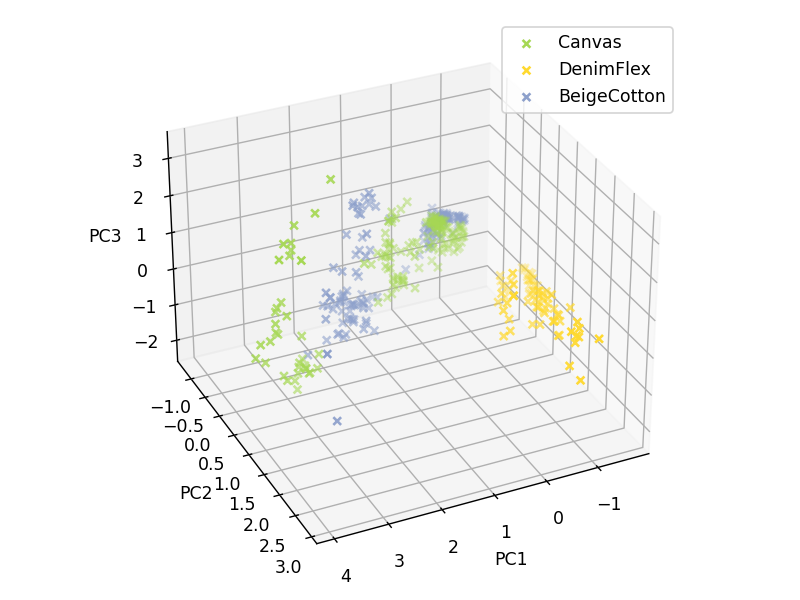

<IPython.core.display.Javascript object>


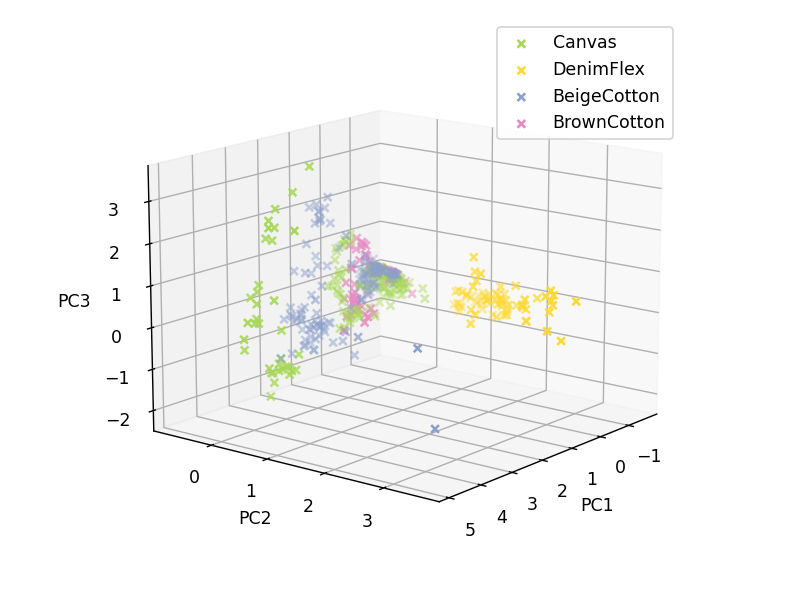

<IPython.core.display.Javascript object>


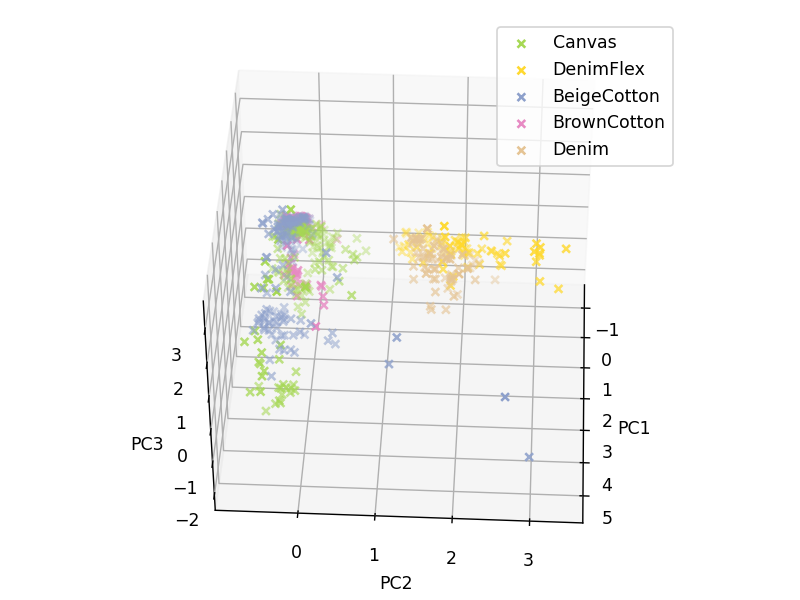

<IPython.core.display.Javascript object>


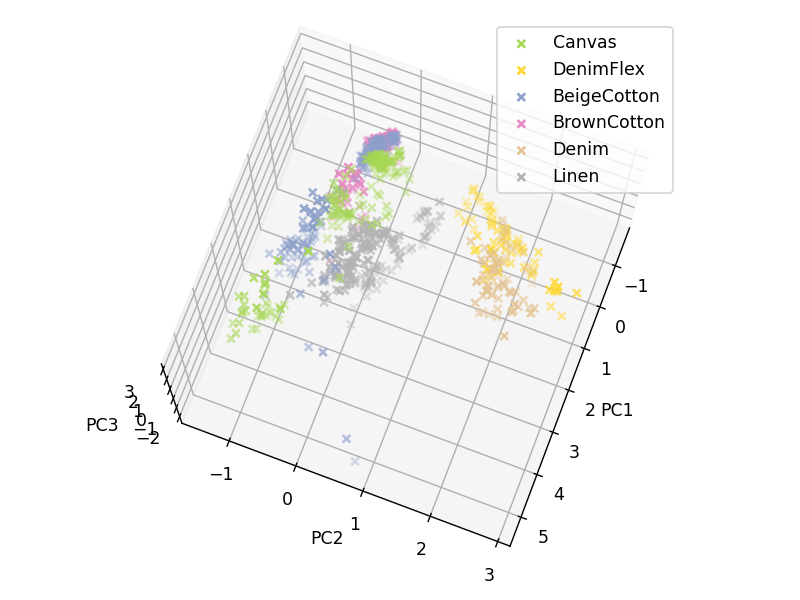

<IPython.core.display.Javascript object>


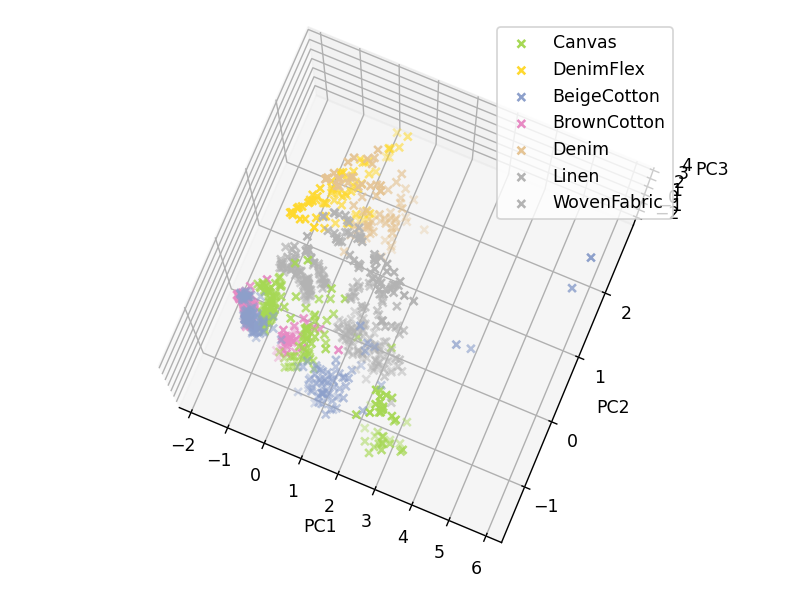

In [47]:
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

%matplotlib notebook

NPC = 3

ipca = IncrementalPCA(n_components=NPC)
clf = KNeighborsClassifier(n_neighbors=10)
train_x, train_y, test_x, test_y, other_x, other_y = split_train_test(coeffs, df_label, [2, 3], False)

# Fit PCA feature extractor with initial training set
# Transform train, test, other datasets into initial feature space
ipca.partial_fit(train_x)
trainXd = ipca.transform(train_x)
testXd = ipca.transform(test_x)
otherXd = ipca.transform(other_x)
clf.fit(trainXd, train_y["texture"])

# Initial feature space
plot3d(trainXd, train_y, "texture")
plt.legend()

# Proceed with each test sample
for new_tex in test_y["texture"].unique():
    select_id = test_y[test_y["texture"] == new_tex].index
    select_x = test_x[select_id, :]
    y_selected = test_y.iloc[select_id]
    
    # Transform the test point into feature space
    x = ipca.transform(select_x)
    y_pred = clf.predict(x)
    
    if np.sum(select_x) > 0:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")
        plot3d(trainXd, train_y, "texture", ax=ax)
        plot3d(x, y_selected, "texture", ax=ax)
        ax.legend()
    
    ipca.partial_fit(select_x)
    train_x = np.vstack([train_x, select_x])
    train_y = pd.concat([train_y, y_selected], axis=0)
    train_y.reset_index(drop=True, inplace=True)
    trainXd = ipca.transform(train_x)
    
plt.show() 

# Plot One Sample in Both Time and Frequency Domain

In [ ]:
import matplotlib.pyplot as plt

%matplotlib notebook

ds = TacDataset('data', transform=None)
transformer = ResampleFFT(64)
cmap = plt.cm.get_cmap("tab20", 16)

sample, param, label = ds[119]
x = sample
y = transformer(x)
freq = np.linspace(1, 32, 64)

fig1, ax1 = plt.subplots(figsize=(9, 5), nrows=1, ncols=1)
fig1.subplots_adjust(right=0.8)

fig2, ax2 = plt.subplots(figsize=(9, 5), nrows=1, ncols=1)
fig2.subplots_adjust(right=0.8)

for i in range(16):
    ax1.plot(x[:, i], c=cmap(i), label="channel {}".format(i+1))
    ax2.plot(freq, y[:, i], c=cmap(i), label="channel {}".format(i+1))
    

ax1.set_ylabel("sensor values")
ax1.set_xlabel("time(s)")
ax1.set_title("{} @ pressure: {}, speed: {}mm/s".format(ds.get_texture_name(label), param[0], param[1]))

ax2.set_xlabel("frequency(Hz)")
ax2.set_ylabel("strength")
ax2.set_title("{} @ pressure: {}, speed: {}mm/s".format(ds.get_texture_name(label), param[0], param[1]))

ax1.legend(loc='center left', bbox_to_anchor=(0.8, 0.5))
ax2.legend(loc='center left', bbox_to_anchor=(0.8, 0.5))
plt.show()

In [ ]:
reps = 3
rate = np.zeros((reps, 10))
var_ratio = np.zeros((reps, 10))
for i in range(10):
    for j in range(reps):
        transformer, trainXd, train_label, test_coeff, test_label, other_coeff, other_label = extractXd(i+1)
        var_ratio[j, i] = np.sum(transformer.explained_variance_ratio_[:i+1])
        testXd = transformer.transform(test_coeff)
        allXd = np.vstack([trainXd, testXd])
        allLabel = np.hstack([train_label["id"].values, test_label["id"].values])
        # Convert label to 1-hot array
        h = np.zeros((allLabel.size, allLabel.max()+1))
        h[np.arange(allLabel.size),allLabel] = 1
        
        clf = KNeighborsClassifier(10, weights="distance")
        X_train, X_test, Y_train, Y_test = train_test_split(allXd, h, test_size=0.5, random_state=42)
        clf.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)
        rate[j, i] = accuracy_score(Y_test, Y_pred)

In [ ]:
from scipy.stats import linregress

transformer, trainXd, train_label, test_coeff, test_label, other_coeff, other_label = extractXd(3, 4)
coeffXd = transformer.transform(coeffs)
df1 = pd.DataFrame(coeffXd, columns=["x", "y", "z"])
df = pd.concat([df0, df1], axis=1)

df = df[~df["texture"].str.contains("Board")]
for p in df["pressure"].unique():
    df_ = df[df["pressure"] == p]
    for tex in df_["texture"].unique():
        dfx = df_[df_["texture"] == tex]
        res = linregress(dfx[["x", "y"]].values, dfx["z"])
    plot3df(df_, "texture")
    plt.title("Pressure {}".format(p))
    plt.tight_layout()

In [ ]:
def mscatter(x,y,z, ax=None, m=None, **kw):
    import matplotlib.markers as mmarkers
    ax = ax or plt.gca()
    sc = ax.scatter(x,y,z,**kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

transformer, trainXd, train_label, test_coeff, test_label, other_coeff, other_label = extractXd(3)
testXd = transformer.transform(test_coeff)
df1 = pd.DataFrame(np.vstack([trainXd, testXd]), columns=["x", "y", "z"])
df = pd.concat([df0, df1], axis=1)
df_denims = df[df["texture"].str.contains("Denim")]

marker = dict({120: "x", 150: "o", 180: "P", 210: "$F$"})

denims = df_denim["texture"].unique()
cmap = plt.cm.get_cmap("Accent", len(denims))
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
for i, denim in enumerate(denims):
    dd = df_denims[df_denims["texture"] == denim]
    marker_list = list(map(lambda x: marker[x], dd["pressure"]))
    mscatter(dd["x"], dd["y"], dd["z"], ax=ax, m=marker_list, s=30, c=np.tile(cmap(i), (len(dd), 1)), label=denim)
ax.legend()
plt.show()

In [ ]:
transformer, trainXd, train_label, test_coeff, test_label, other_coeff, other_label = extractXd(3)

coeff_splits = np.array_split(test_coeff, 5, axis=0)
coeffXd = transformer.transform(coeffs)
df1 = pd.DataFrame(coeffXd, columns=["x", "y", "z"])
df = pd.concat([df0, df1], axis=1)
    
plot3df(df, "texture")
for coeff in coeff_splits:
    transformer.partial_fit(coeff)
    coeffXd = transformer.transform(coeffs)
    df1 = pd.DataFrame(coeffXd, columns=["x", "y", "z"])
    df = pd.concat([df0, df1], axis=1)
    
    plot3df(df, "texture")
    plt.show()

In [ ]:
plt.figure()
plt.boxplot(var_ratio)
plt.plot(np.arange(10)+1, np.mean(var_ratio, axis=0), label='ratio of variance')
plt.grid()
plt.xlabel("n_components")
plt.ylabel("accuracy_score")
plt.legend()
plt.show()

# Construct RNN-AutoEncoder (RAE)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence


class Encoder(nn.Module):
    """ Recurent Variational Autoencoder """
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, device, dropout=0.3):
        super(Encoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.device = device
        
        self.rnn = nn.GRU(input_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc_mu = nn.Linear(hidden_dim, output_dim)
        self.fc_var = nn.Linear(hidden_dim, output_dim)
        
        self.to(device)
        
    def forward(self, x):
        packed_in = pack_padded_sequence(x[0].to(self.device), x[1].cpu().numpy(), batch_first=True)
        rnn_out, self.hidden = self.rnn(packed_in)
        x_in = self.hidden[-1].squeeze()
        mu = self.fc_mu(x_in)
        var = self.fc_var(x_in)
        
        return mu
    
    def init_hidden(self, batch_dim):
        return (torch.zeros(self.n_layers, batch_dim, self.hidden_dim, device=self.device),
                torch.zeros(self.n_layers, batch_dim, self.hidden_dim, device=self.device))


class RVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, encoding_dim, extra_dim, output_dim, n_layers, device):
        super(RVAE, self).__init__()
        self.device = device
        
        self.encoder = Encoder(input_dim, hidden_dim, encoding_dim, n_layers, device)
        self.classifier = nn.Sequential(
            nn.Linear(encoding_dim, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim),
            nn.Sigmoid()
        ).to(device)

    def forward(self, x):
        encoded = self.encode(x[:2])
        # x_in = torch.hstack([encoded, x[2].to(self.device)])
        y = self.classifier(encoded)

        return y

    def encode(self, x):
        return self.encoder(x)
    
""" Custom collate functions"""

class PadSequence(object):
    def __call__(self, batch):
        # Each element in "batch" is a tuple (data, label).
        # Sort the batch in the descending order
        sorted_batch = sorted(batch, key=lambda x: x[0].shape[0], reverse=True)
        # Get each sequence and pad it
        sequences = [torch.tensor(x[0], dtype=torch.float) for x in sorted_batch]
        sequences_padded = pad_sequence(
            sequences, batch_first=True)
        # Store the length of each sequence
        lengths = torch.tensor([len(x) for x in sequences])
        params = torch.tensor(list(map(lambda x: x[1], sorted_batch)), dtype=torch.float)
        labels = torch.tensor(list(map(lambda x: x[2], sorted_batch)))
        return sequences_padded, lengths, params, labels

# Train the network

In [ ]:
import matplotlib.pyplot as plt
import torch
from torch import optim
from torch.utils.data import DataLoader

BATCH_SIZE = 8
EPOCHS = 10
INPUT_DIM = 16
NUM_CLASS = ds.count_class()

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

train_loader = DataLoader(ds, batch_size=BATCH_SIZE, collate_fn=PadSequence(), num_workers=6, shuffle=True)
rvae = RVAE(input_dim=INPUT_DIM, hidden_dim=16, encoding_dim=3, extra_dim=2, output_dim=NUM_CLASS, n_layers=3, device=device)
loss_list = []

def train_once(x, y, model, optimizer, criterion):
    optimizer.zero_grad()
    output = model(x)
    target = y.to(device)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    
    return loss.item()
    
def train_model(data_loader, model):
    optimizer = optim.SGD(model.parameters(), lr = 1e-3)
    criterion = nn.CrossEntropyLoss()
    # loss_list = []
    
    for epoch in range(EPOCHS):
        running_loss = 0.0
        
        for i, (batch, lengths, params, targets) in enumerate(data_loader):
            loss = train_once((batch, lengths, params), targets, model, optimizer, criterion)
            running_loss += loss
            loss_list.append(loss)
            
            if i % 10 == 9:
                print('Epoch {}, {:.2f}% - loss: {:.6f}'.format(epoch + 1, 100.0 * (i + 1.0) / len(data_loader), running_loss / 10))
                running_loss = 0.0
                
    print("Training finished.")
    plt.figure()
    plt.plot(loss_list)
    plt.title("Training Recurrent Autoencoder")
    plt.xlabel("Run")
    plt.ylabel("Loss")
    plt.show()
    
train_model(train_loader, rvae)